# Research on apartment sales ads

You will have the data from a real estate agency. It is an archive of sales ads for realty in St. Petersburg, Russia, and the surrounding areas collected over the past few years. You’ll need to learn how to determine the market value of real estate properties. Your task is to define the parameters. This will make it possible to build an automated system that is capable of detecting anomalies and fraudulent activity.

There are two different types of data available for every apartment for sale. The first type is a user’s input. The second type is received automatically based upon the map data. For example, the distance from the downtown area, airport, the nearest park or body of water. 

### Step 1. Open the data file and study the general information. 

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
df = pd.read_csv('real_estate_data_eng.csv', sep='\t')

In [4]:
print(df.head())

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony     locality_name  airports_nearest  \
0          25.0      NaN   Saint Peterburg           18863.0   
1     

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

In [6]:
print(df.describe())

       total_images    last_price    total_area         rooms  ceiling_height  \
count  23699.000000  2.369900e+04  23699.000000  23699.000000    14504.000000   
mean       9.858475  6.541549e+06     60.348651      2.070636        2.771499   
std        5.682529  1.088701e+07     35.654083      1.078405        1.261056   
min        0.000000  1.219000e+04     12.000000      0.000000        1.000000   
25%        6.000000  3.400000e+06     40.000000      1.000000        2.520000   
50%        9.000000  4.650000e+06     52.000000      2.000000        2.650000   
75%       14.000000  6.800000e+06     69.900000      3.000000        2.800000   
max       50.000000  7.630000e+08    900.000000     19.000000      100.000000   

       floors_total   living_area         floor  kitchen_area       balcony  \
count  23613.000000  21796.000000  23699.000000  21421.000000  12180.000000   
mean      10.673824     34.457852      5.892358     10.569807      1.150082   
std        6.597173     22.030445

### Conclusion

Looking at the data, it appears we have quite a few null data points in some categories, which will require some further exploration and data interpolation. Some of these stick out as eaiser to fill than others. 

I also note some oddities in existing data -12 square meters seems too small for any appartment, while 900 square meters seems way too large. We see other data points that seem outlandish as well -in fact, many max values are well above the 75th percentile, which could suggest either misentered data, fraudulent data, or in some cases just an outlier that would likely not adhere to trends in the data.

### Step 2. Data preprocessing

In [7]:
df['balcony'].fillna(0, inplace=True)

In [8]:
df['ceiling_height'].fillna(df['ceiling_height'].median(), inplace=True)

In [9]:
df['floors_total'].fillna(df['floors_total'].median(), inplace=True)

In [10]:
def apt_size(size):
    if size <= 52:
        return 'small'
    if 52 < size <= 69:
        return 'medium'
    if size > 69: 
        return 'large'

In [11]:
df['apt_size'] = df['total_area'].apply(apt_size)

In [12]:
mapper1 = df.groupby('apt_size')['kitchen_area'].mean().to_dict()

In [13]:
mapper2 = df.groupby('apt_size')['living_area'].mean().to_dict()

In [14]:
def fill_kitchen(row):
    if np.isnan(row['kitchen_area']) or row['kitchen_area'] is None:
        return mapper1[row['apt_size']]
    return row['kitchen_area']

df['kitchen_area'] = df.apply(fill_kitchen, axis=1)

In [15]:
def fill_living(row):
    if np.isnan(row['living_area']) or row['living_area'] is None:
        return mapper2[row['apt_size']]
    return row['living_area']

df['living_area'] = df.apply(fill_living, axis=1)

In [16]:
df['is_apartment'].fillna(0, inplace=True)

In [17]:
df['is_apartment'] = df['is_apartment'].astype('bool')

In [18]:
df['cityCenters_nearest'].fillna(df['cityCenters_nearest'].mean(), inplace=True)

In [19]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23699 non-null float64
living_area             23699 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 23699 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     23699 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around3000

### Conclusion

The first thing we are looking at here is null/missing values. I worked down the list based on the info() method to see what columns are missing data. For many categories, it was inappropriate to replace null values. However, the balcony column seemed easy enough -specifically, if they are null, it likely suggests they don't have a balcony. Ultimately, both ceiling_height and floors_total are not likely to have a big impact on our investigation. As such, I replaced all null values here with the median values. 

I also wanted to fill in values such as living_area and kitchen_area based on other factors (i.e. total_area and rooms). Rather than take the overall mean/median however, I wanted to be more specific. So, I used the total area to group apartments in different categories. Based on those categories, I took the mean areas for that category and interpolated that value in the null areas. Another "easy" value to fill is is_apartment. Since we know it's True or False, I filled all null entries with 0. 

Next, there's no accurate way to fill in many of the remaining nulls. Parks, ponds, city centers, airports -since we're not likely to need details on these metrics, it might be better to leave them null. In doing so, we might discover those with null values are more likely to belong to fraudulent listings. I might end up filling these later, or dropping some rows. But, for now I want to continue with the investigation.

Aside from this, our days_exposition null values likely show the apartment ad is still live. We might need to leave such apartments out of future calculations, but for now I am leaving the values since these can still be helpful data points. 

### Step 3. Make calculations and add them to the table

In [20]:
df['price_per_meter'] = df['last_price'] / df['total_area']

In [21]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'])

In [22]:
df['pct_kitchen'] = df['kitchen_area'] / df['total_area']

In [23]:
df['pct_living'] = df['living_area'] / df['total_area']

In [24]:
def find_floor(row):
    if row["floor"] == 1:
        return 'first'
    if row["floor"] == row['floors_total']:
        return 'last'
    else:
        return 'other'
 
df['rel_floor'] = df.apply(find_floor, axis=1)

In [25]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 27 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23699 non-null float64
living_area             23699 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 23699 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     23699 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_ar

### Conclusion

Much of the data in this step is to better understand the layout of apartments. Finding the price_per_meter within specific geographical areas can be helpful in real estate becaus legitamate listings should have similarities. Similarly, the ratio of the kitchen/living area to the overall size of the apartment may reveal some oddities that could point to fradulent listings. Finally, having the relative floor may point to some trends -i.e. are first-story or top-story apartments priced higher normally? Having added these columns of interest, we can now better examine the data. 

### Step 4. Conduct exploratory data analysis and follow the instructions below:

In [26]:
df[['total_area', 'last_price', 'ceiling_height', 'rooms']].corr()

,total_area,last_price,ceiling_height,rooms
total_area,1.000000,0.653675,0.080613,0.758344
last_price,0.653675,1.000000,0.064425,0.363343
ceiling_height,0.080613,0.064425,1.000000,0.047991
rooms,0.758344,0.363343,0.047991,1.000000


In [27]:
df[['total_area', 'last_price', 'ceiling_height', 'rooms']].describe()

,total_area,last_price,ceiling_height,rooms
count,23699.000000,2.369900e+04,23699.000000,23699.000000
mean,60.348651,6.541549e+06,2.724358,2.070636
std,35.654083,1.088701e+07,0.988298,1.078405
min,12.000000,1.219000e+04,1.000000,0.000000
25%,40.000000,3.400000e+06,2.600000,1.000000
50%,52.000000,4.650000e+06,2.650000,2.000000
75%,69.900000,6.800000e+06,2.700000,3.000000
max,900.000000,7.630000e+08,100.000000,19.000000


In [28]:
df['total_area'].hist(bins=20, range=(10, 300))

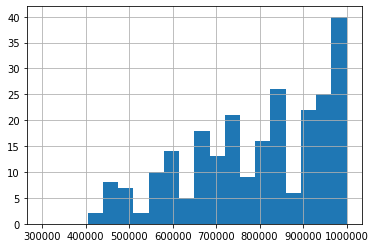

In [29]:
df['last_price'].hist(bins=20, range=(300000, 1000000))

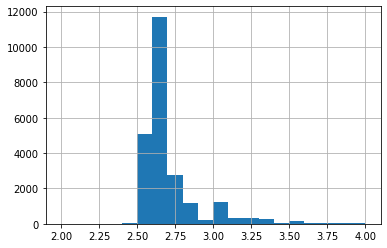

In [30]:
df['ceiling_height'].hist(bins=20, range=(2, 4))

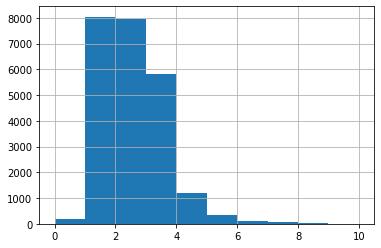

In [31]:
df['rooms'].hist(bins=10, range=(0, 10))

In [32]:
df['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [33]:
df['days_exposition'].mean()

180.88863436982163

In [34]:
df['days_exposition'].median()

95.0

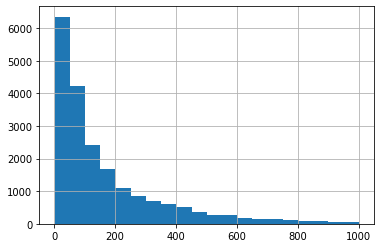

In [35]:
df['days_exposition'].hist(bins=20, range=(1, 1000))

In [36]:
sales_time = df[df['days_exposition'] <= 400]

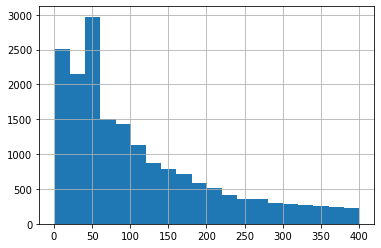

In [37]:
sales_time['days_exposition'].hist(bins=20, range=(1, 400))

In [38]:
sales_time['days_exposition'].mean()

111.32470219786366

In [39]:
price = df[['first_day_exposition', 'last_price', 'total_area', 'rooms', 'rel_floor', 'cityCenters_nearest']]

In [40]:
price.head()

,first_day_exposition,last_price,total_area,rooms,rel_floor,cityCenters_nearest
0,2019-03-07,13000000.0,108.0,3,other,16028.0
1,2018-12-04,3350000.0,40.4,1,first,18603.0
2,2015-08-20,5196000.0,56.0,2,other,13933.0
3,2015-07-24,64900000.0,159.0,3,other,6800.0
4,2018-06-19,10000000.0,100.0,2,other,8098.0


In [41]:
price.corr()

,last_price,total_area,rooms,cityCenters_nearest
last_price,1.000000,0.653675,0.363343,-0.201921
total_area,0.653675,1.000000,0.758344,-0.220448
rooms,0.363343,0.758344,1.000000,-0.168599
cityCenters_nearest,-0.201921,-0.220448,-0.168599,1.000000


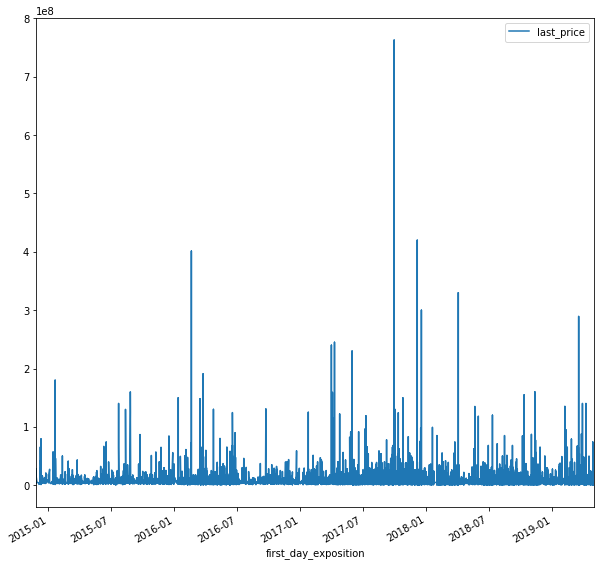

In [42]:
price.plot(x='first_day_exposition', y='last_price', figsize=(10,10))

In [43]:
flr = df.pivot_table(index='rel_floor', values='last_price', aggfunc=['mean', 'median'])

In [44]:
flr

,mean,median
,last_price,last_price
rel_floor,,
first,4.803560e+06,3900000.0
last,7.356777e+06,4300000.0
other,6.676061e+06,4850000.0


The first thing I wanted to do was examine some correlations between different metrics. As one might expect, the number of rooms and price were both closely correlated with the total area of the apartment. However, the correlation between the number of rooms and price was weaker than I expected. With this in mind, I dug a bit deeper into the data. 

Looking at exposition times, we see right off that bat that a few outliers skew the data. With the mean being almost double the median, this shows strong outliers are pulling the mean. As such, I looked more closely at values under 400 days. This was still a bit generous, but by looking at this our mean is brought much closer to the overall median values. And, looking at this data, we can see that most apartments sell within 100 days of being listed. 

After this, we explore correlations again, focusing in on whether city center location (distance to downtown) might have an impact on price. Instead, we again consider that price is most closely correlated to total area and find that being close to downtown actually has a negative correlation on price. In other words, buying downtown may be less expensive. 

We then explore listing dates for ads and compare this with the last price. This clearly shows trends in the data that could indicate times where apartment prices were at their highest. 

Next, I wanted to take a closer look at localities and see how trends might look within certain areas. 

In [45]:
df['locality_name'].nunique()

341

In [46]:
df['locality_name'].value_counts().head(10)

Saint Peterburg      15721
Murino village         556
Shushary village       440
Vsevolozhsk            398
Pushkin                369
Kolpino                338
Pargolovo village      327
Gatchina               307
Kudrovo village        299
Vyborg                 237
Name: locality_name, dtype: int64

In [47]:
locations = ['Saint Peterburg', 'Murino village', 'Shushary village', 'Vsevolozhsk', 'Pushkin', 'Kolpino',
            'Pargolovo village', 'Gatchina', 'Kudrovo village ', 'Vyborg']

In [48]:
subset = df.query('locality_name in @locations')

In [49]:
table = subset.pivot_table(index='locality_name', values=['total_area', 'last_price', 'ceiling_height', 'rooms', 'price_per_meter'], 
                       aggfunc=['mean', 'median'])

In [50]:
table

mean                                          \
                  ceiling_height    last_price price_per_meter     rooms   
locality_name                                                              
Gatchina                2.714039  3.488337e+06    68746.146763  1.921824   
Kolpino                 2.626834  3.964021e+06    75424.579098  2.130178   
Kudrovo village         2.680301  4.234158e+06    92473.547576  1.438127   
Murino village          2.754838  3.652361e+06    85681.762601  1.390288   
Pargolovo village       2.641743  4.488075e+06    90175.913458  1.605505   
Pushkin                 2.685935  6.469036e+06   103125.819291  2.018970   
Saint Peterburg         2.748790  8.062507e+06   114849.008794  2.171618   
Shushary village        2.647273  4.108082e+06    78677.364217  1.804545   
Vsevolozhsk             2.667513  3.789068e+06    68654.473986  1.914573   
Vyborg                  2.682574  3.250983e+06    58141.909153  2.122363   

                                     median                                   \
                  total_area ceiling_height last_price price_per_meter rooms   
locality_name                                                                  
Gatchina           50.942932           2.65  3100000.0    67796.610169     2   
Kolpino            53.231479           2.65  3600000.0    74723.748474     2   
Kudrovo village    46.571739           2.65  3790000.0    91860.465116     1   
Murino village     43.961403           2.65  3400000.0    85878.462169     1   
Pargolovo village  51.521407           2.65  4100000.0    91642.857143     1   
Pushkin            61.552791           2.65  5180000.0   100000.000000     2   
Saint Peterburg    64.751488           2.65  5500000.0   104761.904762     2   
Shushary village   53.821273           2.65  3950000.0    76876.172608     2   
Vsevolozhsk        56.022186           2.65  3450000.0    65789.473684     2   
Vyborg             56.150042           2.65  2897000.0    58158.319871     2   

                              
                  total_area  
locality_name                 
Gatchina               45.00  
Kolpino                50.00  
Kudrovo village        39.90  
Murino village         37.40  
Pargolovo village      43.00  
Pushkin                53.20  
Saint Peterburg        55.00  
Shushary village       50.10  
Vsevolozhsk            53.55  
Vyborg                 50.20

In [51]:
df['downtown'] = (df['cityCenters_nearest'] / 1000).astype('int')

In [52]:
data = df[df['locality_name'] == 'Saint Peterburg']

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15721 entries, 0 to 23697
Data columns (total 28 columns):
total_images            15721 non-null int64
last_price              15721 non-null float64
total_area              15721 non-null float64
first_day_exposition    15721 non-null datetime64[ns]
rooms                   15721 non-null int64
ceiling_height          15721 non-null float64
floors_total            15721 non-null float64
living_area             15721 non-null float64
floor                   15721 non-null int64
is_apartment            15721 non-null bool
studio                  15721 non-null bool
open_plan               15721 non-null bool
kitchen_area            15721 non-null float64
balcony                 15721 non-null float64
locality_name           15721 non-null object
airports_nearest        15636 non-null float64
cityCenters_nearest     15721 non-null float64
parks_around3000        15660 non-null float64
parks_nearest           7284 non-null float64
ponds_ar

In [54]:
pivot = data.pivot_table(index='downtown', values='last_price', aggfunc=['mean', 'median'])

In [55]:
pivot

,mean,median
,last_price,last_price
downtown,,
0,2.344232e+07,11750000.0
1,1.885085e+07,10835000.0
2,1.616331e+07,9500000.0
3,1.343683e+07,8500000.0
4,1.363202e+07,9900000.0
5,1.530612e+07,8920262.0
6,1.438911e+07,8005000.0
7,1.279767e+07,7500000.0


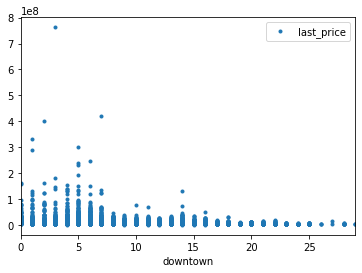

In [56]:
data.plot(x='downtown', y='last_price', marker='.', linestyle='none')

In [57]:
downtown = data[data['downtown'] < 8]

In [58]:
downtown.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3712 entries, 3 to 23694
Data columns (total 28 columns):
total_images            3712 non-null int64
last_price              3712 non-null float64
total_area              3712 non-null float64
first_day_exposition    3712 non-null datetime64[ns]
rooms                   3712 non-null int64
ceiling_height          3712 non-null float64
floors_total            3712 non-null float64
living_area             3712 non-null float64
floor                   3712 non-null int64
is_apartment            3712 non-null bool
studio                  3712 non-null bool
open_plan               3712 non-null bool
kitchen_area            3712 non-null float64
balcony                 3712 non-null float64
locality_name           3712 non-null object
airports_nearest        3706 non-null float64
cityCenters_nearest     3712 non-null float64
parks_around3000        3712 non-null float64
parks_nearest           2453 non-null float64
ponds_around3000        371

In [59]:
dt_data = downtown[['total_area', 'last_price', 'rooms', 'ceiling_height', 'rel_floor', 'downtown', 'first_day_exposition', 'price_per_meter']]

In [60]:
dt_data.corr()

,total_area,last_price,rooms,ceiling_height,downtown,price_per_meter
total_area,1.000000,0.636407,0.737234,0.129019,-0.112126,0.251342
last_price,0.636407,1.000000,0.333342,0.070637,-0.052142,0.779992
rooms,0.737234,0.333342,1.000000,0.101393,-0.180955,0.006247
ceiling_height,0.129019,0.070637,0.101393,1.000000,-0.134776,0.043099
downtown,-0.112126,-0.052142,-0.180955,-0.134776,1.000000,-0.030952
price_per_meter,0.251342,0.779992,0.006247,0.043099,-0.030952,1.000000


In [61]:
dt_data.describe()

,total_area,last_price,rooms,ceiling_height,downtown,price_per_meter
count,3712.000000,3.712000e+03,3712.000000,3712.000000,3712.000000,3.712000e+03
mean,92.328303,1.472962e+07,2.813308,2.943570,4.195582,1.444049e+05
std,60.531664,2.470451e+07,1.456235,0.721477,1.757304,9.184454e+04
min,12.000000,1.600000e+06,0.000000,2.000000,0.000000,1.534527e+04
25%,56.000000,6.590000e+06,2.000000,2.650000,3.000000,1.000000e+05
50%,77.760000,9.000000e+06,3.000000,2.800000,4.000000,1.236292e+05
75%,108.725000,1.413138e+07,3.000000,3.102500,5.000000,1.549658e+05
max,900.000000,7.630000e+08,19.000000,32.000000,7.000000,1.907500e+06


In [62]:
good_dt_data = dt_data.query('total_area < 200')

In [63]:
good_dt_data.describe()

,total_area,last_price,rooms,ceiling_height,downtown,price_per_meter
count,3532.000000,3.532000e+03,3532.000000,3532.000000,3532.000000,3.532000e+03
mean,82.493055,1.200375e+07,2.658834,2.929238,4.215176,1.401168e+05
std,36.580098,1.254318e+07,1.209316,0.724393,1.754104,7.908646e+04
min,12.000000,1.600000e+06,0.000000,2.000000,0.000000,1.534527e+04
25%,55.000000,6.500000e+06,2.000000,2.650000,3.000000,1.000000e+05
50%,75.200000,8.800000e+06,3.000000,2.800000,4.000000,1.229337e+05
75%,102.100000,1.300128e+07,3.000000,3.100000,5.000000,1.532504e+05
max,198.000000,3.300000e+08,11.000000,32.000000,7.000000,1.736842e+06


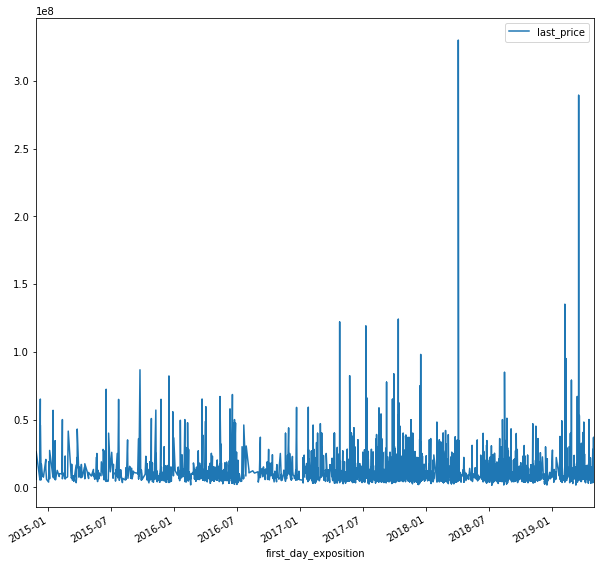

In [64]:
good_dt_data.plot(x='first_day_exposition', y='last_price', figsize=(10,10))

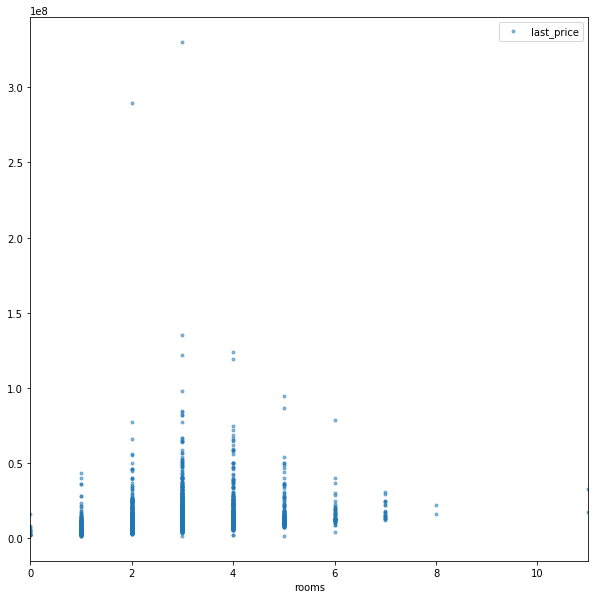

In [65]:
good_dt_data.plot(x='rooms', y='last_price', figsize=(10,10), marker='.', linestyle='none', alpha=0.5)

In [66]:
floors = good_dt_data.pivot_table(index='rel_floor', values='last_price', aggfunc=['mean', 'median'])

In [67]:
floors

,mean,median
,last_price,last_price
rel_floor,,
first,8.574804e+06,6500000.0
last,1.205241e+07,8800000.0
other,1.253666e+07,9245000.0


### Conclusion

Looking closely at locations, we see Saint Peterburg and Pushkin have the highest price per meter. they also have the highest sale prices listed. We also recognize that median is a more accurate measure. As before, there are strong outliers that skew the mean of this data set. 

Since St. Peterburg is one of the most expensive and it also has the most listings by a large margin, we focused in on that city in particular next. Here we wanted to look more closely at the downtown area, which appears to be within about 5 km of the city center. With that in mind, we narrowed down our exploration further to just those within 7km of downtown in Saint Petersburg. 

Initially, we look for correlations here to see how it matches up to general apartment data -it appears similar, but total_area has a slightly lower correlation on price. Similarly, distance to downtown is less correlated. Together, this could indicate that apartments downtown are closer in price regardless of other factors. 

Looking at descriptive statistics for individual columns, we also recognize some of the earlier outliers. For this reason, we drop the outliers and do some further digging. We see spikes in the sale price based on when the ad was published similar to original data. However, it definitely has less noise overall -in other words, we still see some spikes in price, but not as severe as the overall trend. This could suggest downtown is less impacted when apartment prices are high. 

We also see that the number of rooms seems to hit a point where more rooms actually end up hurting the price. This could be due to low demand, maintenance costs, or other factors. But, overall it seems having 3-4 rooms tends to be the sweet spot if you're looking at value. Finally, we see apartments on the last floor tend to be much more valuable than those on the first. However, those on neither nor last tend to be the most valuable, on average. 

### Step 5. Overall conclusion

Despite what we see initially, it seems clear that apartments located in downtown Saint Petersburg have a much higher price tag than those located elsewhere. While the overall data seems to flow in the same direction, we also see a more pronounced impact on certain factors. Specifically, downtown apartments on the first floor are much less expensive than those on other floors. However, in general, apartment floors show a small variance in price. 

Alternatively, we find apartment prices downtown are all higher overall and as a general rule vary less than the big picture. This suggests the most expensive units in our general sample are heavily impacted by the cost of those downtown. 